# Plain vs. Parallel Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def myimgshow(plt,img):
    plt.gray()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

## Load image

In [3]:
path = './test_data/'
#img_name = "phantom256"
img_name = "brain_sagittal.jpg"
img_path = path + img_name #+ ".png"
img_pil = Image.open(img_path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

In [4]:
img_np.shape,img_var.shape

((1, 256, 256), torch.Size([1, 1, 256, 256]))

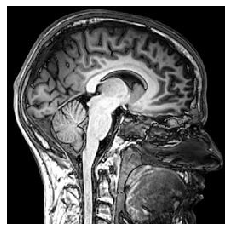

In [5]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Define network

In [20]:
output_depth = img_np.shape[0]
num_channels0 = 84
num_channels = 50
rnd = 500
numit = 10000
rn = 0.001
maxv = np.max(img_np)

num_layers0 = 4
plainnet = skipdecoder(output_depth,num_layers0,num_channels0,skips=False).type(dtype)

decoders_numlayers_list = [2,3,4] # #layers for each decoding block
decoders_last_channels = [40,40,40]
net = pardecoder(num_output_channels = output_depth,
                 num_channels=num_channels,
                 decoders_numlayers_list = decoders_numlayers_list,
                 decoders_last_channels = decoders_last_channels).type(dtype)

print("plain params:",num_param(plainnet))
print("parallel params:", num_param(net))

print("train plain") 
mse_n, mse_t, plainni, plainnet = fit( num_channels=[num_channels0]*(num_layers0-1),
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_var,
                        net=plainnet,
                        img_clean_var=img_var,
                        find_best=True,
                        )
out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
print("plain psnr:",psnr(img_np,out_img_np,maxv),"\n")

print("train parallel") 
mse_n, mse_t, ni, net = fit( num_channels=[num_channels]*(max(decoders_numlayers_list)-1),
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                        #orth_reg=0.1,
                        )
out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
print("parallel psnr:",psnr(img_np,out_img_np,maxv),"\n")

plain params: 21756
parallel params: 21720
train plain
shape:  [1, 84, 32, 32]
optimize with adam 0.0025
plain psnr: 29.749651208189356 .001324  Actual loss 0.001324 Actual loss orig 0.001324  Noise Energy 0.000000  

train parallel
shape:  [1, 50, 32, 32]
optimize with adam 0.0025
parallel psnr: 28.06602923616278 01616  Actual loss 0.001616 Actual loss orig 0.001616  Noise Energy 0.000000      

